<a href="https://colab.research.google.com/github/yyyyyokoko/590FaceMaskDetection/blob/master/590_MobileNetV2_for_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os, random
import pathlib
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16, VGG19
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import cv2

from tensorflow.keras.models import load_model



In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/Face Mask Dataset/sample_training"

mask  nomask


In [ ]:
data_train = '/content/drive/My Drive/Colab Notebooks/Face Mask Dataset/Validation/'
data_train

'/content/drive/My Drive/Colab Notebooks/Face Mask Dataset/Validation/'

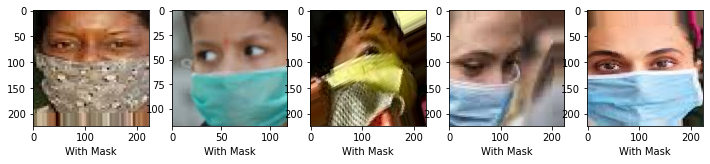

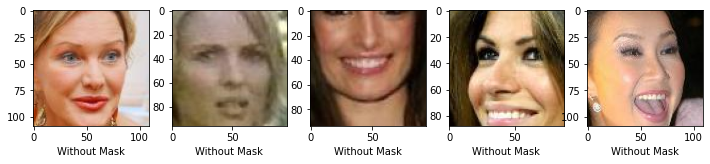

In [ ]:
#with Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(data_train+"mask/"))
    plt.subplot(1,5,i+1)
    img = load_img(data_train+"mask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("With Mask")
    plt.imshow(img)
plt.show()

#without Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(data_train+"nomask/"))
    plt.subplot(1,5,i+1)
    img = load_img(data_train+"nomask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("Without Mask")
    plt.imshow(img)
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        rescale=1./255,
        horizontal_flip=True,
        validation_split=0.2)

train = train_datagen.flow_from_directory(directory=data_train,target_size=(160,160),
                                          class_mode="categorical",
                                          classes={'nomask': 0, 'mask': 1},
                                          batch_size=32,subset = "training")


valid = train_datagen.flow_from_directory(directory=data_train,target_size=(160,160),
                                          class_mode="categorical",
                                          classes={'nomask': 0, 'mask': 1},
                                          batch_size=32,subset="validation")

Found 526 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [ ]:
valid.class_indices

{'mask': 1, 'nomask': 0}

In [39]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(160, 160, 3)), classifier_activation="sigmoid")

for layer in baseModel.layers:
    layer.trainable = False

model = Sequential()
model.add(baseModel)
model.add(Flatten())
model.add(Dense(2,activation="sigmoid"))


In [41]:

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 25602     
Total params: 14,740,290
Trainable params: 25,602
Non-trainable params: 14,714,688
_________________________________________________________________


In [42]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")


In [43]:
checkpoint = ModelCheckpoint("moblenet_facemask.h5",monitor="val_accuracy",save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [44]:
history = model.fit_generator(train,
                              epochs=10,
                              validation_data=valid,
                              callbacks=[checkpoint])


Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 0.3696 - accuracy: 0.8232
Epoch 00001: val_accuracy improved from -inf to 0.97692, saving model to moblenet_facemask.h5
17/17 [==============================] - 6s 367ms/step - loss: 0.3696 - accuracy: 0.8232 - val_loss: 0.1032 - val_accuracy: 0.9769
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9677
Epoch 00002: val_accuracy did not improve from 0.97692
17/17 [==============================] - 6s 336ms/step - loss: 0.0921 - accuracy: 0.9677 - val_loss: 0.0639 - val_accuracy: 0.9769
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9848
Epoch 00003: val_accuracy improved from 0.97692 to 0.98462, saving model to moblenet_facemask.h5
17/17 [==============================] - 6s 340ms/step - loss: 0.0641 - accuracy: 0.9848 - val_loss: 0.0436 - val_accuracy: 0.9846
Epoch 4/10
17/17 [==============================] - ETA: 0s - loss: 0.0346 - ac

### Evaluation 

In [69]:
import pandas as pd
training_accuary = pd.DataFrame.from_dict(history.history).drop(columns = ['val_loss', 'val_accuracy'])

test_data = "/content/drive/My Drive/Colab Notebooks/Face Mask Dataset/sample_training"
test = train_datagen.flow_from_directory(directory=test_data,target_size=(160,160),
                                          class_mode="categorical",
                                          classes={'nomask': 0, 'mask': 1},
                                          batch_size=32)
model.evaluate(valid)

Found 96 images belonging to 2 classes.
5/5 [==============================] - 1s 170ms/step - loss: 0.0122 - accuracy: 1.0000


[0.012210500426590443, 1.0]

In [70]:
model.evaluate(train)

17/17 [==============================] - 5s 266ms/step - loss: 0.0125 - accuracy: 1.0000


[0.012540963478386402, 1.0]

In [71]:
model.evaluate(test)

3/3 [==============================] - 1s 186ms/step - loss: 0.0627 - accuracy: 0.9792


[0.06268831342458725, 0.9791666865348816]

In [58]:
training_accuary



,loss,accuracy
0,0.369633,0.823194
1,0.092086,0.967681
2,0.064143,0.984791
3,0.034592,0.992395
4,0.037865,0.988593
5,0.026790,0.988593
6,0.025019,0.992395
7,0.015856,1.000000
8,0.023745,0.996198
9,0.013006,0.998099


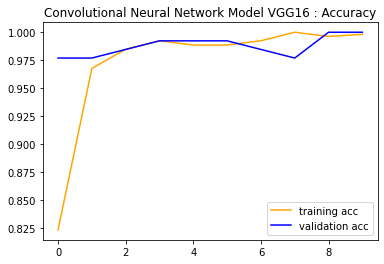

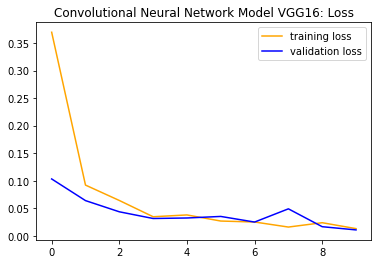

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Convolutional Neural Network Model VGG16 : Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training loss')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation loss')
plt.title('Convolutional Neural Network Model VGG16: Loss')
plt.legend()
plt.show()

In [60]:
model.save("/content/drive/My Drive/Colab Notebooks/face_mask_vgg16.h5")


In [74]:
model = load_model('/content/drive/My Drive/Colab Notebooks/face_mask_vgg16.h5')

pred = model.predict_classes(valid)

pred_probs = model.predict(valid)

In [75]:
pred_probs[:10]

array([[2.56733310e-05, 3.23003203e-01],
       [2.29311869e-01, 3.86179199e-05],
       [4.23664041e-02, 6.03930675e-05],
       [8.78946483e-01, 3.33132448e-07],
       [4.04164675e-05, 1.20372064e-01],
       [4.68054699e-04, 4.81799953e-02],
       [1.47047234e-04, 1.84266772e-02],
       [1.95013478e-01, 6.76671189e-05],
       [2.34407149e-02, 6.83262013e-04],
       [2.45129107e-04, 2.56279949e-02]], dtype=float32)

In [76]:
pred

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0])